In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from tqdm import tqdm
import seaborn as sns

In [7]:
cd

C:\Users\Lione


In [8]:
FILEPATH = "Repositories/ada-2023-project-welovepandas/dataset"

beers = pd.read_csv(f'{FILEPATH}/matched_beer_data/beers.csv', header=[0, 1])
breweries = pd.read_csv(f'{FILEPATH}/matched_beer_data/breweries.csv', header=[0, 1])
ratings = pd.read_csv(f'{FILEPATH}/matched_beer_data/ratings.csv', header=[0, 1])
users = pd.read_csv(f'{FILEPATH}/matched_beer_data/users.csv', header=[0, 1])

# Grouping some of the beer styles together

IPA_filtered = ratings.ba[ratings.ba['style'].str.contains('IPA| Indian Pale Ale', case=True)].sort_values(by='date').copy()
lager_filtered = ratings.ba[ratings.ba['style'].str.contains('Lager', case=False)].sort_values(by='date').copy()
stout_filtered = ratings.ba[ratings.ba['style'].str.contains('Stout', case=False)].sort_values(by='date').copy()
weizen_filtered = ratings.ba[ratings.ba['style'].str.contains('weizen', case=False)].sort_values(by='date').copy()
pilsener_filtered = ratings.ba[ratings.ba['style'].str.contains('Pilsener', case=False)].sort_values(by='date').copy()

display(ratings.ba.columns)

Index(['abv', 'appearance', 'aroma', 'beer_id', 'beer_name', 'brewery_id',
       'brewery_name', 'date', 'overall', 'palate', 'rating', 'review',
       'style', 'taste', 'text', 'user_id', 'user_name'],
      dtype='object')

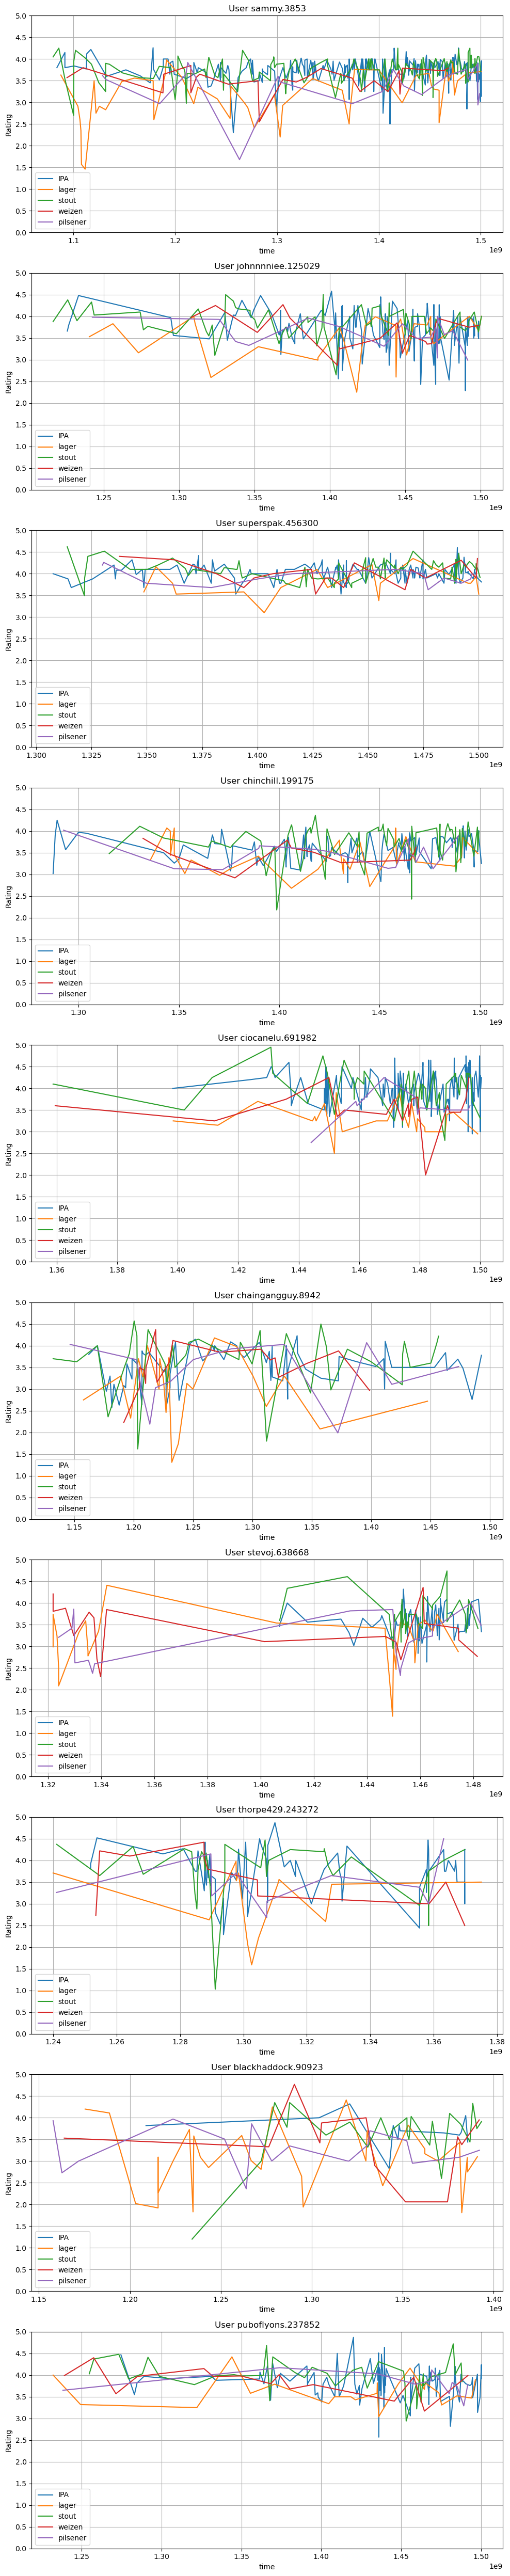

In [9]:
# Selecting top 10 highest contributors from BA matched -> Think shouldn't use matched set for this
# There seems to be insufficient data

user_id_top10 = ratings.ba.groupby('user_id').count().sort_values(by='beer_id', ascending=False).head(10).index

fig, ax = plt.subplots(10, 1, figsize=(10, 50))
for index, user in enumerate(user_id_top10): #
#    print('IPA:', IPA_filtered[IPA_filtered['user_id'] == user].shape[0])
#    print('lager:',lager_filtered[lager_filtered['user_id'] == user].shape[0])
#    print('stout:',stout_filtered[stout_filtered['user_id'] == user].shape[0])
#    print('weizen:',weizen_filtered[weizen_filtered['user_id'] == user].shape[0])
#    print('pilsener:',pilsener_filtered[pilsener_filtered['user_id'] == user].shape[0])
    x_IPA = IPA_filtered[IPA_filtered['user_id'] == user].date
    x_lager = lager_filtered[lager_filtered['user_id'] == user].date
    x_stout = stout_filtered[stout_filtered['user_id'] == user].date
    x_weizen = weizen_filtered[weizen_filtered['user_id'] == user].date
    x_pilsener = pilsener_filtered[pilsener_filtered['user_id'] == user].date

    y_IPA = IPA_filtered[IPA_filtered['user_id'] == user].rating
    y_lager = lager_filtered[lager_filtered['user_id'] == user].rating
    y_stout = stout_filtered[stout_filtered['user_id'] == user].rating
    y_weizen = weizen_filtered[weizen_filtered['user_id'] == user].rating
    y_pilsener = pilsener_filtered[pilsener_filtered['user_id'] == user].rating

    ax[index].plot(x_IPA, y_IPA, label='IPA')
    ax[index].plot(x_lager, y_lager, label='lager')
    ax[index].plot(x_stout, y_stout, label='stout')
    ax[index].plot(x_weizen, y_weizen, label='weizen')
    ax[index].plot(x_pilsener, y_pilsener, label='pilsener')
    ax[index].set_title(f'User {user}')
    ax[index].legend()
    ax[index].set_ylim(0, 5)
    ax[index].set_yticks(np.arange(0, 5.5, 0.5))
    ax[index].set_xlabel('time')
    ax[index].set_ylabel('Rating')
    ax[index].grid()

plt.tight_layout()




I think in general we would need some form of adding up the data in a useful manner. There's such a high variance because I think those people simply try a lot of beer and some stouts are shit and others aren't.. Need some purposeful averaging but for this more data is needed.
Ideas could be:
-   Use moving average for trend
-   to filter out outliers I.e. removing beers that globally have bad ratings
-   group directly by e.g. country
-   Useful grouping of beer styles (I did not check all styles just used some famous ones that I know)

NOTES: 
-   It's clear that some styles get way less reviews than others, this has to be considered too
-   Some people (as can be seen from plots) have taken longer breaks of review, which of course affects the dynamics by not changing for longer time periods.. how to deal with those? Since we cannot just assume that they did not drink beer during this time (cutting out those epoches does not make sense), we could completely neglect those cases? Maybe check how often this occurs first? But I think it might be a good idea to select "active users" only over the time periods we consider




In [10]:
## Redo with only BA dataset
import re # regex

from load_reviews import load_reviews
import wordcloud
import spacy
nlp = spacy.load('en_core_web_sm')

beers_BA = pd.read_csv(f'{FILEPATH}/BeerAdvocate/beers.csv')
breweries_BA = pd.read_csv(f'{FILEPATH}/BeerAdvocate/breweries.csv')
users_BA = pd.read_csv(f'{FILEPATH}/BeerAdvocate/users.csv')

In [15]:
reviews = load_reviews(f'{FILEPATH}/BeerAdvocate/reviews.txt').dropna()
display(reviews)

Loading reviews from Repositories/ada-2023-project-welovepandas/dataset/BeerAdvocate/reviews.txt
Number of lines: 44022962


100%|██████████| 44022962/44022962 [01:33<00:00, 472453.11it/s]


,beer_id,user_id,date,overall,rating,text
1044348,93,todd.2,8.407080e+08,4.00,3.85,"Presentation: Pint size, on tap from the Easts..."
1025529,111,todd.2,8.844300e+08,4.00,4.19,Presentation: 8.45oz blue bottle with gold let...
494422,97,beeradvocate.1,8.846892e+08,4.50,4.10,Presentation: It is so pleasing to obtain beer...
1958517,51,beeradvocate.1,8.853804e+08,4.00,3.77,Presentation: Bottle and six-pack carrier have...
26272,306,beeradvocate.1,8.854668e+08,1.00,1.60,Presentation: 12oz. green bottle.Appearance: B...
...,...,...,...,...,...,...
2354286,78838,woodbrew.549902,1.501495e+09,4.00,3.93,I'm trying this at my Bestie's in Charlotte. I...
2534668,5366,blackop555.1183557,1.501495e+09,3.00,2.98,"Pours golden. Foamy, short, white head that fa..."
2173272,355,andrewh995.1184297,1.501495e+09,3.75,3.91,Pours a clear honey gold with minimal white he...
2479210,34312,mtn.766653,1.501582e+09,3.75,3.79,"2012 vintage. Seems like an infected bottle, ..."


In [16]:
reviews_beer = reviews.merge(beers_BA[['beer_id', 'beer_name', 'brewery_id', 'brewery_name', 'style']],
                             how = 'inner',
                             on='beer_id')
display(reviews_beer.columns)

Index(['beer_id', 'user_id', 'date', 'overall', 'rating', 'text', 'beer_name',
       'brewery_id', 'brewery_name', 'style'],
      dtype='object')

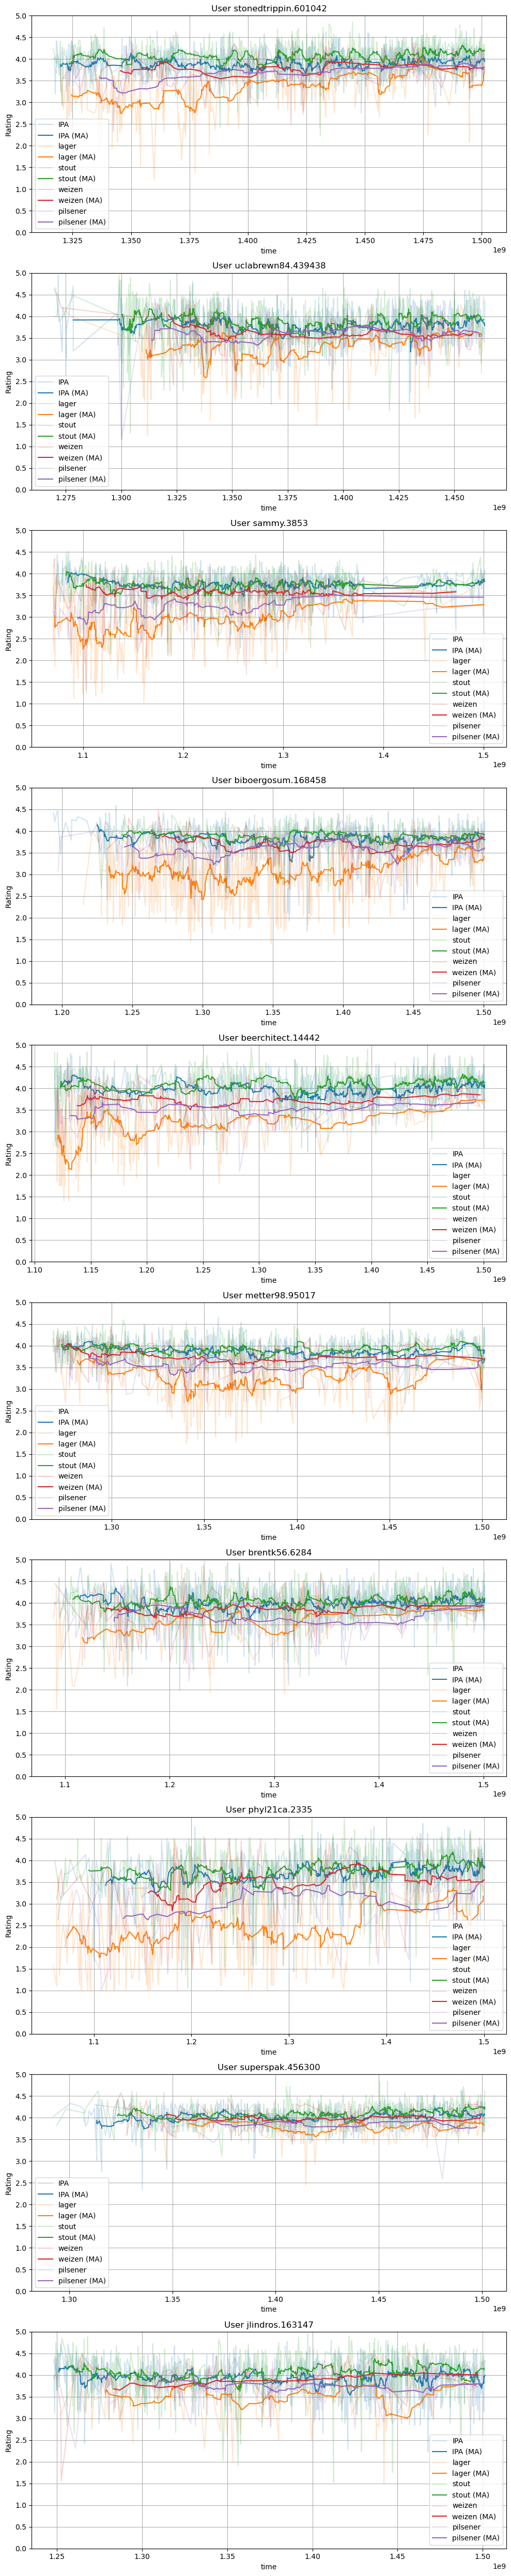

In [23]:
from matplotlib.cm import get_cmap
from matplotlib.colors import to_rgba

# Grouping same styles as before and plotting top 10

IPA_filtered = reviews_beer[reviews_beer['style'].str.contains('IPA| Indian Pale Ale', case=True)].sort_values(by='date').copy()
lager_filtered = reviews_beer[reviews_beer['style'].str.contains('Lager', case=False)].sort_values(by='date').copy()
stout_filtered = reviews_beer[reviews_beer['style'].str.contains('Stout', case=False)].sort_values(by='date').copy()
weizen_filtered = reviews_beer[reviews_beer['style'].str.contains('weizen', case=False)].sort_values(by='date').copy()
pilsener_filtered = reviews_beer[reviews_beer['style'].str.contains('Pilsener', case=False)].sort_values(by='date').copy()

user_id_top10 = reviews_beer.groupby('user_id').count().sort_values(by='beer_id', ascending=False).head(10).index

fig, ax = plt.subplots(10, 1, figsize=(10, 50))
for index, user in enumerate(user_id_top10): #
#    print('IPA:', IPA_filtered[IPA_filtered['user_id'] == user].shape[0])
#    print('lager:',lager_filtered[lager_filtered['user_id'] == user].shape[0])
#    print('stout:',stout_filtered[stout_filtered['user_id'] == user].shape[0])
#    print('weizen:',weizen_filtered[weizen_filtered['user_id'] == user].shape[0])
#    print('pilsener:',pilsener_filtered[pilsener_filtered['user_id'] == user].shape[0])

    styles = ['IPA', 'lager', 'stout', 'weizen', 'pilsener']
    cmap = get_cmap('tab10')

    for indx, style in enumerate(styles):
        x = eval(f"{style}_filtered[{style}_filtered['user_id'] == user].date")
        y = eval(f"{style}_filtered[{style}_filtered['user_id'] == user].rating")

        # choose color from cmap
        colour = cmap(indx % cmap.N)

        # Calculate the moving average
        y_ma = y.rolling(window=15).mean()

        # Plot the original ratings
        ax[index].plot(x, y, color=colour, alpha=0.2, label=style)

        # Plot the moving average
        ax[index].plot(x, y_ma, color=colour, label=f'{style} (MA)')

    ax[index].set_title(f'User {user}')
    ax[index].legend()
    ax[index].set_ylim(0, 5)
    ax[index].set_yticks(np.arange(0, 5.5, 0.5))
    ax[index].set_xlabel('time')
    ax[index].set_ylabel('Rating')
    ax[index].grid()

plt.tight_layout()


When considering all data from BA for the top10 reviewers and also plotting a MA (windowsize=15 here) a naive look at the plots show:
-   The different beer styles seem to converge slightly for almost all users here
-   In many cases Lager beers seem to get better reviews over time (pilsener slightly too)
-   stouts and IPA remain rather constant at $\pm 4.0$
-   Variance varies a lot between styles. Lager especially, which makes sense though since it is the most accesible (and often  also cheapest) that does not target beer fanatics per se
-   Users have different habits of rating (either their tastes differ that much from other or they just rate differently)
-> We see e.g. people that almost always rate aroung +/-4 some vary their scores more strongly

One thing that came to my mind when doing something like this is, that maybe the location aspect has to be considered. Because Americans probably drink way more American Lager than Europeans, and if there is an "objective" difference between those kinds of Lager this might influence the trends / overall ratings